In [1]:
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import seaborn as sns
import numpy as np
import pickle
from joblib import Parallel, delayed
from math import log2, ceil
from scipy.ndimage import zoom
from scipy import ndimage
import time
import os
import pandas as pd

from proglearn.forest import LifelongClassificationForest
# import proglearn.docs.tutorials.functions.rotation_cifar_functions as fn
from proglearn.progressive_learner import ProgressiveLearner
from proglearn.deciders import SimpleArgmaxAverage
from proglearn.transformers import TreeClassificationTransformer, NeuralClassificationTransformer
from proglearn.voters import TreeClassificationVoter, KNNClassificationVoter

import SimpleITK as sitk
from skimage.util import img_as_ubyte
from skimage.transform import rotate
from multiprocessing import Pool
from functools import partial

In [2]:
context = sns.plotting_context(context="talk", font_scale=1)
sns.set_context(context)

In [6]:
# (X_train, y_train), (X_test, y_test) = keras.datasets.cifar100.load_data()

169009152/169001437 [==============================] - 120s 1us/step


In [3]:
# data = [(X_train, y_train), (X_test, y_test)]

# pickle_out = open("data.pickle", "wb")
# pickle.dump(data, pickle_out)
# pickle_out.close()

pickle_in = open("data.pickle", "rb")
data = pickle.load(pickle_in)

# with open('data.pickle', 'rb') as f:
#      data = pickle.load(f)

In [4]:
(X_train, y_train) = data[0]
(X_test, y_test) = data[1]
data_x = np.concatenate([X_train, X_test])
data_y = np.concatenate([y_train, y_test])
data_y = data_y[:, 0]

In [5]:
def image_aug(pic, angle, centroid_x=23, centroid_y=23, win=16, scale=1.45):
    im_sz = int(np.floor(pic.shape[0]*scale))
    pic_ = np.uint8(np.zeros((im_sz,im_sz,3),dtype=int))

    pic_[:,:,0] = ndimage.zoom(pic[:,:,0],scale)

    pic_[:,:,1] = ndimage.zoom(pic[:,:,1],scale)
    pic_[:,:,2] = ndimage.zoom(pic[:,:,2],scale)

    image_aug = rotate(pic_, angle, resize=False)
    image_aug_ = image_aug[centroid_x-win:centroid_x+win,centroid_y-win:centroid_y+win,:]

    return img_as_ubyte(image_aug_)

In [6]:
def init_forest(max_depth):
    np.random.seed(1)
    default_transformer_class = TreeClassificationTransformer
    default_transformer_kwargs = {"kwargs" : {"max_depth" : max_depth}}
    default_voter_class = TreeClassificationVoter
    default_voter_kwargs = {}
    default_decider_class = SimpleArgmaxAverage
    progressive_learner = ProgressiveLearner(default_transformer_class = default_transformer_class,
                             default_transformer_kwargs = default_transformer_kwargs,
                             default_voter_class = default_voter_class,
                             default_voter_kwargs = default_voter_kwargs,
                             default_decider_class = default_decider_class)
    return progressive_learner

In [ ]:
def cross_val_data(data_x, data_y, total_cls=10, n_train=250):
    x = data_x.copy()
    y = data_y.copy()
    idx = [np.where(data_y == u)[0] for u in np.unique(data_y)]
    for i in range(total_cls):
        indx = idx[i]#np.roll(idx[i],(cv-1)*100)
        random.shuffle(indx)
        if i==0:
            train_x1 = x[indx[0:n_train],:]
            train_x2 = x[indx[n_train:n_train*2],:]
            train_y1 = y[indx[0:n_train]]
            train_y2 = y[indx[n_train:n_train*2]]
            test_x = x[indx[500:600],:]
            test_y = y[indx[500:600]]
        else:
            train_x1 = np.concatenate((train_x1, x[indx[0:250],:]), axis=0)
            train_x2 = np.concatenate((train_x2, x[indx[250:500],:]), axis=0)
            train_y1 = np.concatenate((train_y1, y[indx[0:250]]), axis=0)
            train_y2 = np.concatenate((train_y2, y[indx[250:500]]), axis=0)
            test_x = np.concatenate((test_x, x[indx[500:600],:]), axis=0)
            test_y = np.concatenate((test_y, y[indx[500:600]]), axis=0)
    return train_x1, train_y1, train_x2, train_y2, test_x, test_y

In [7]:
def exp(angle, data_x, data_y, max_depth, reps=1, ntrees=29, acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
    errors = np.zeros(3)
    ites_for_angles = {15:'500',30:'750',45:'1000',60:'3000'}
    sitk_n_fails = 0
    for rep in range(reps):
        train_x1, train_y1, train_x2, train_y2, test_x, test_y = fn.cross_val_data(
            data_x, data_y, total_cls=10
        )
        tmp_data = train_x2.copy()
        tmp_data_sitk = train_x2.copy()
        _tmp_ = np.zeros((32, 32, 3), dtype=int)
        total_data = tmp_data.shape[0]

        for i in range(3):
            tmp_ = fn.image_aug(tmp_data[i], angle)
            tmp_data[i] = tmp_
            target = rotate(train_x2[i], angle)
            try:
                tmp_data_sitk[i] = run_elastix(template=train_x2[i], target=target, ite=ites_for_angles[angle])
            except:
                tmp_data_sitk[i] = tmp_
                sitk_n_fails += 1

        train_x1 = train_x1.reshape(
            (train_x1.shape[0], train_x1.shape[1] * train_x1.shape[2] * train_x1.shape[3])
        )
        tmp_data = tmp_data.reshape(
            (tmp_data.shape[0], tmp_data.shape[1] * tmp_data.shape[2] * tmp_data.shape[3])
        )
        test_x = test_x.reshape(
            (test_x.shape[0], test_x.shape[1] * test_x.shape[2] * test_x.shape[3])
        )
        tmp_data_sitk = tmp_data_sitk.reshape(
            (tmp_data_sitk.shape[0], tmp_data_sitk.shape[1] * tmp_data_sitk.shape[2] * tmp_data_sitk.shape[3])
        )
        
        # L2F
        progressive_learner = init_forest(ntrees, max_depth) 
        progressive_learner.add_task(X=train_x1, y=train_y1)
        llf_single_task = progressive_learner.predict(test_x, task_id=0)
        progressive_learner.add_transformer(X=tmp_data, y=train_y2)
        llf_task1 = progressive_learner.predict(test_x, task_id=0)
        
        # L2F o sitk
        progressive_learner = init_forest(ntrees, max_depth)
        progressive_learner.add_task(X=train_x1, y=train_y1)
        progressive_learner.add_transformer(X=tmp_data_sitk, y=train_y2)
        llf_task1_sitk = progressive_learner.predict(test_x, task_id=0)

        errors[1] = errors[1] + (1 - np.mean(llf_task1 == test_y))
        errors[0] = errors[0] + (1 - np.mean(llf_single_task == test_y))
        errors[2] = errors[1] + (1 - np.mean(llf_task1_sitk == test_y))

    errors = (errors / reps)
    return errors

In [8]:
def run_elastix(template, target, ite):
    elastixImageFilter = sitk.ElastixImageFilter()
    elastixImageFilter.SetFixedImage(sitk.GetImageFromArray(template))
    elastixImageFilter.SetMovingImage(sitk.GetImageFromArray(target))
    ParamMap = sitk.GetDefaultParameterMap('affine')
    ParamMap['AutomaticTransformInitialization'] = ['true']
    ParamMap['AutomaticTransformInitializationMethod'] = ['GeometricalCenter']
    ParamMap['MaximumNumberOfIterations'] = [ite]
    ParamMap['UseDirectionCosines'] = ['true']
    # ParamMap['NumberOfResolutions'] = ['2']
    # ParamMap['NumberOfSpatialSamples'] = ['3000']
    ParamMap['UseAdaptiveStepSizes'] = ['true']

    # new
    ParamMap["FixedImagePyramid"] = ["FixedShrinkingImagePyramid"] 
    ParamMap["MovingImagePyramid"] = ["MovingShrinkingImagePyramid"] 
    ParamMap["Transform"] = ["EulerTransform"]
    ParamMap['AutomaticScalesEstimation'] = ["true"]
#     ParamMap['AutomaticParameterEstimation'] = ['false']
    ParamMap['SP_A'] = ['50']
    ParamMap['SP_alpha'] = ['0.6']
#     ParamMap['Metric'] = ['NormalizedMutualInformation']
    ParamMap['NewSamplesEveryIteration'] = ['true']
#     ParamMap['NumberOfSpatialSamples'] = ['3000']
#     ParamMap['SampleRegionSize'] = ['200']

    # Set the parameter map:
    elastixImageFilter.SetParameterMap(ParamMap)

    # Register the 3D images:
    elastixImageFilter.Execute()

    # Get the registered image:
    RegIm = elastixImageFilter.GetResultImage()
    RegIm_array = sitk.GetArrayFromImage(RegIm)
    diff = RegIm_array.max() - RegIm_array.min()
    RegIm_array = (RegIm_array - RegIm_array.min()) / diff
    return RegIm_array

In [9]:
cd proglearn/docs/tutorials/functions/

/proglearn/docs/tutorials/functions


In [10]:
import rotation_cifar_functions as fn

In [11]:
cd ../../../..

/


#### plot samples

In [12]:
train_x1, train_y1, train_x2, train_y2, test_x, test_y = fn.cross_val_data(data_x, data_y, total_cls=10)

In [37]:
i = 1500
angle = 30
template = train_x2[i]
target = rotate(template, angle)

In [38]:
RegIm = run_elastix(template, target, '750')

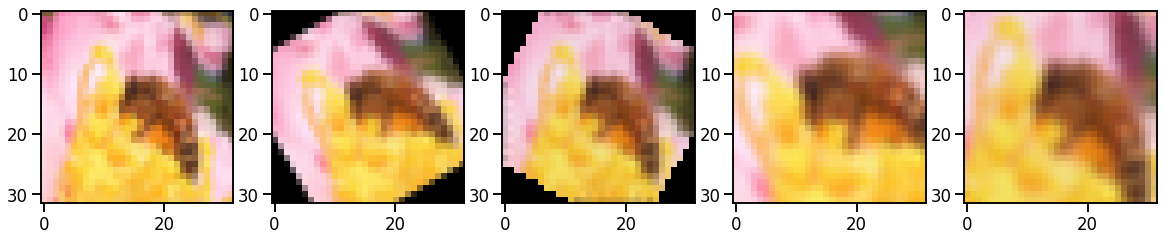

In [39]:
fig,axs = plt.subplots(1,5, figsize=(20,4))
axs[0].imshow(template)
axs[1].imshow(target)
axs[2].imshow(RegIm)
axs[3].imshow(fn.image_aug(template,angle))
axs[4].imshow(fn.image_aug(img_as_ubyte(RegIm),0))

In [34]:
idx = 750
i,j,k = rotate_img(train_x2, 30, idx)

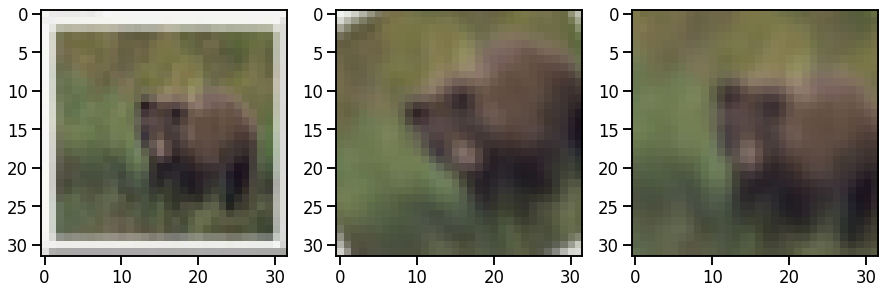

In [35]:
fig,axs = plt.subplots(1,3, figsize=(15,5))
axs[0].imshow(train_x2[idx])
axs[1].imshow(i)
axs[2].imshow(j)

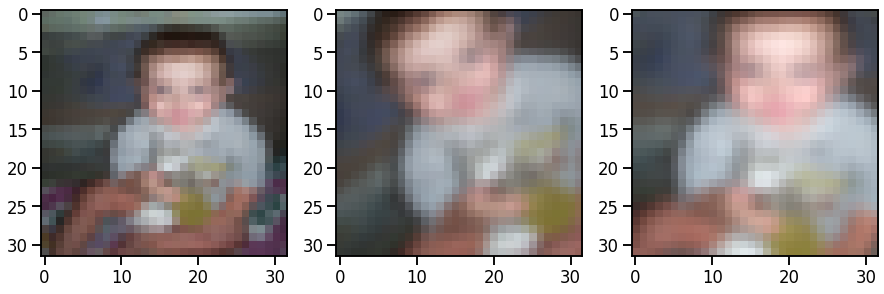

In [18]:
idx = 700; angle = 30; ites_for_angles = {15:'500',30:'750',45:'1000',60:'3000'}
tmp_ = image_aug(train_x2[idx], angle)
template = train_x2[idx]
target = rotate(train_x2[idx], angle)
tmp_sitk_ = run_elastix(template=template, target=target, ite=ites_for_angles[angle])
fig,axs = plt.subplots(1,3,figsize=(15,5))
axs[0].imshow(train_x2[idx])
axs[2].imshow(image_aug(img_as_ubyte(tmp_sitk_),0))
axs[1].imshow(tmp_)

#### compute errors & BTE

In [12]:
granularity = 20; max_depth = 30; reps = 2; ntrees=16
# angle = 15
# angles = np.arange(0, 181, granularity)
angles = np.array([15, 30])

In [13]:
# errors_array = []
# start_time = time.time()
# with Pool(8) as p:
#     errors_array.append(
#         p.map(partial(exp, data_x=data_x, data_y=data_y, max_depth=max_depth, reps=reps, ntrees=16, acorn=1), angles)
#     )
# print("--- %s seconds ---" % (time.time() - start_time))

In [22]:
errors_array

[[array([0., 0., 0.]), array([0., 0., 0.])]]

In [19]:
def rotate_img(train_x2, angle, i):
    ites_for_angles = {15:'500',30:'750',45:'1000',60:'3000'}
    tmp_ = image_aug(train_x2[i], angle)
    template = train_x2[i]
    target = rotate(train_x2[i], angle)
    sitk_fails = False
    try:
        tmp_sitk_ = run_elastix(template=template, target=target, ite=ites_for_angles[angle])
    except:
        tmp_sitk_ = target
        sitk_fails = True
    return tmp_, image_aug(img_as_ubyte(tmp_sitk_),0), sitk_fails


In [28]:
def exp_parallel(angle, data_x, data_y, max_depth, ntrees=29):
    errors = np.zeros(3)
    train_x1, train_y1, train_x2, train_y2, test_x, test_y = fn.cross_val_data(
        data_x, data_y, total_cls=10
    )
    total_data = train_x2.shape[0]

    img_rot = Parallel(n_jobs=-1, verbose=1)(
                delayed(rotate_img)(train_x2=train_x2, angle=angle , i=ite) for ite in range(total_data)
            )
    print("finished rotating images")
    tmp_data = np.array([img_rot[i][0] for i in range(len(img_rot))])
    tmp_data_sitk = np.array([img_rot[i][1] for i in range(len(img_rot))])
    sitk_n_fails = np.sum(np.array([img_rot[i][2] for i in range(len(img_rot))]))
    
    train_x1 = train_x1.reshape(
        (train_x1.shape[0], train_x1.shape[1] * train_x1.shape[2] * train_x1.shape[3])
    )
    tmp_data = tmp_data.reshape(
        (tmp_data.shape[0], tmp_data.shape[1] * tmp_data.shape[2] * tmp_data.shape[3])
    )
    test_x = test_x.reshape(
        (test_x.shape[0], test_x.shape[1] * test_x.shape[2] * test_x.shape[3])
    )
    tmp_data_sitk = tmp_data_sitk.reshape(
        (tmp_data_sitk.shape[0], tmp_data_sitk.shape[1] * tmp_data_sitk.shape[2] * tmp_data_sitk.shape[3])
    )

    # L2F
    progressive_learner = init_forest(max_depth) 
    progressive_learner.add_task(
        X = train_x1, y = train_y1,
        transformer_voter_decider_split = [0.67, 0.33, 0],
        decider_kwargs = {"classes" : np.unique(train_y1)}    
    )
    progressive_learner.add_transformer(
        X = tmp_data, y = train_y2,
        transformer_data_proportion = 1, backward_task_ids = [0]
    )
    llf_single_task = progressive_learner.predict(test_x, task_id=0, transformer_ids=[0])
    llf_task1 = progressive_learner.predict(test_x, task_id=0)

    # L2F o sitk
    progressive_learner_sitk = init_forest(max_depth)
    progressive_learner_sitk.add_task(
        X = train_x1, y = train_y1,
        transformer_voter_decider_split = [0.67, 0.33, 0],
        decider_kwargs = {"classes" : np.unique(train_y1)}    
    )
    progressive_learner_sitk.add_transformer(
        X = tmp_data_sitk, y = train_y2,
        transformer_data_proportion = 1, backward_task_ids = [0]
    )
    llf_task1_sitk = progressive_learner_sitk.predict(test_x, task_id=0)

    errors[0] = 1 - np.mean(llf_single_task == test_y)
    errors[1] = 1 - np.mean(llf_task1 == test_y)
    errors[2] = 1 - np.mean(llf_task1_sitk == test_y)
    
    return errors, sitk_n_fails

In [21]:
max_depth = 30; ntrees = 16

In [22]:
errors_15_1, sitk_fail_15_1 = exp_parallel(
    angle=15, data_x=data_x, data_y=data_y, max_depth=max_depth, ntrees=ntrees
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 190 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 440 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed: 36.8min finished


finished rotating images


In [26]:
print(errors_15_1, sitk_fail_15_1)

array([0.45666667, 0.42666667, 0.41333333])

In [24]:
print(0.45666667/0.42666667, 0.45666667/0.41333333)

1.0703124994506836 1.1048387266519253


In [29]:
errors_30_1, sitk_fail_30_1 = exp_parallel(
    angle=30, data_x=data_x, data_y=data_y, max_depth=max_depth, ntrees=ntrees
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 190 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 440 tasks      | elapsed: 32.8min
[Parallel(n_jobs=-1)]: Done 790 tasks      | elapsed: 58.5min
[Parallel(n_jobs=-1)]: Done 1240 tasks      | elapsed: 90.0min
[Parallel(n_jobs=-1)]: Done 1790 tasks      | elapsed: 148.5min
[Parallel(n_jobs=-1)]: Done 2440 tasks      | elapsed: 198.2min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed: 202.4min finished


finished rotating images


In [30]:
print(errors_30_1, sitk_fail_30_1)

[0.73  0.681 0.706] 16


In [31]:
errors_15_1, sitk_fail_15_1 = exp_parallel(
    angle=15, data_x=data_x, data_y=data_y, max_depth=max_depth, ntrees=ntrees
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 190 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 440 tasks      | elapsed: 20.8min
[Parallel(n_jobs=-1)]: Done 790 tasks      | elapsed: 37.3min
[Parallel(n_jobs=-1)]: Done 1240 tasks      | elapsed: 58.6min
[Parallel(n_jobs=-1)]: Done 1790 tasks      | elapsed: 84.4min
[Parallel(n_jobs=-1)]: Done 2440 tasks      | elapsed: 115.2min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed: 118.0min finished


finished rotating images


In [32]:
print(errors_15_1, sitk_fail_15_1)

[0.739 0.707 0.719] 8


In [33]:
errors_15_2, sitk_fail_15_2 = exp_parallel(
    angle=15, data_x=data_x, data_y=data_y, max_depth=max_depth, ntrees=ntrees
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 190 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 440 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done 790 tasks      | elapsed: 37.3min
[Parallel(n_jobs=-1)]: Done 1240 tasks      | elapsed: 58.4min
[Parallel(n_jobs=-1)]: Done 1790 tasks      | elapsed: 84.4min
[Parallel(n_jobs=-1)]: Done 2440 tasks      | elapsed: 114.9min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed: 117.7min finished


finished rotating images


In [34]:
print(errors_15_2, sitk_fail_15_2)

[0.744 0.728 0.722] 8


In [35]:
errors_30_2, sitk_fail_30_2 = exp_parallel(
    angle=30, data_x=data_x, data_y=data_y, max_depth=max_depth, ntrees=ntrees
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 190 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 440 tasks      | elapsed: 30.8min
[Parallel(n_jobs=-1)]: Done 790 tasks      | elapsed: 55.1min
[Parallel(n_jobs=-1)]: Done 1240 tasks      | elapsed: 86.6min
[Parallel(n_jobs=-1)]: Done 1790 tasks      | elapsed: 125.1min
[Parallel(n_jobs=-1)]: Done 2440 tasks      | elapsed: 170.1min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed: 174.3min finished


finished rotating images


In [36]:
print(errors_30_2, sitk_fail_30_2)

[0.723 0.698 0.714] 16


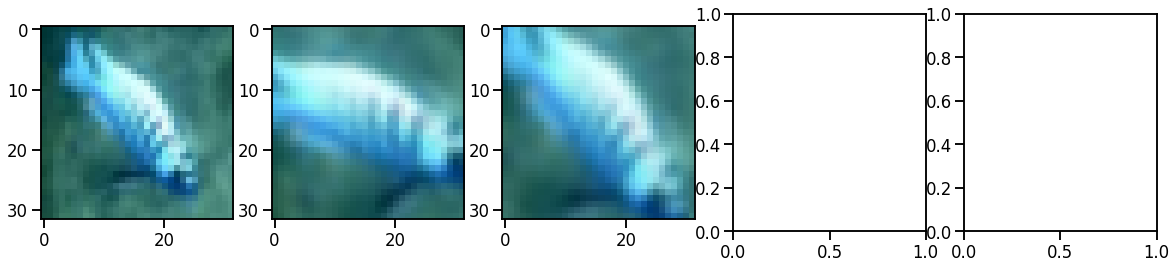

In [101]:
fig,axs = plt.subplots(1,5, figsize=(20,4))
i = 2; j=302
axs[1].imshow(tmp_data[i])
axs[2].imshow(tmp_data_sitk[i])
axs[0].imshow(train_x2[j])
# axs[3].imshow(fn.image_aug(template,angle))
# axs[4].imshow(fn.image_aug(img_as_ubyte(RegIm),0))